### Training Script for Gyroscope Dataset using Hybrid CNN-LSTM Architecture 

@ Author : Niloy Chakraborty

@ Author Contact: chakrabortyniloy2018@gmail.com

In [ ]:
# Connect to Google Colab.  If using Jupyter, then comment this part
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/THESIS/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/THESIS


#### Load the Libraries

In [ ]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
# import tensorflow_addons as tfa


In [ ]:
import os
import yaml

import tensorflow as tf

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import LSTM, Dropout,Dense,RepeatVector,TimeDistributed,Input,BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam as adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.models import load_model

#### Load Training Dataset & Explore

In [ ]:
Category = "Gyr_CNN_LSTM_5_Class"

In [ ]:
# Change File path here
filepath = 'Gyr_25_secs_final_combined_faulty_data_train.csv'

In [ ]:
header = ['AccX','AccY','AccZ','GyrX','GyrY','GyrZ','Altitude','Cmd1','Cmd2','Cmd3','Cmd4','Roll','Pitch','Yaw','ThurstRefOut1','ThurstRefOut2','ThurstRefOut3','ThurstRefOut4','Label']

In [ ]:
df = pd.read_csv(filepath, header = None)
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df = df.iloc[:, 1:]
df["Label"] = pd.to_numeric(df["Label"])
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AccX,AccY,AccZ,GyrX,GyrY,GyrZ,Altitude,Cmd1,Cmd2,Cmd3,Cmd4,Roll,Pitch,Yaw,ThurstRefOut1,ThurstRefOut2,ThurstRefOut3,ThurstRefOut4,Label
1,0.03380774,-0.11192460000000001,-9.492839,-0.0098925,-0.007933972,0.00108462,0.44,342.9332,-342.9577,342.8969,-342.9631,-1.965233e-06,-2.155978e-06,-5.859605e-07,-0.22403289999999998,-0.2240489,-0.22400920000000002,-0.22405239999999998,0
2,-0.116923,-0.2512355,-14.08014,-0.01084344,-0.009036063,-2.253169e-05,0.44,343.0175,-342.912,342.8928,-342.9287,-4.02452e-06,-4.6669999999999995e-06,-7.215308e-08,-0.224088,-0.224019,-0.2240065,-0.22403,0
3,0.22785189999999997,0.06732436,-13.62979,-0.008328836,-0.006301623,0.0025199379999999998,0.44,342.9608,-342.8717,343.0659,-342.8525,6.818334e-06,7.100436999999999e-06,5.960543e-07,-0.2240509,-0.2239928,-0.2241196,-0.22398020000000002,0
4,-0.01241245,-0.1545401,-13.94356,-0.01056849,-0.008493732,0.0007364108,0.44,342.8445,-343.066,342.7531,-343.0873,-3.975494e-06,-3.691068e-06,1.940148e-06,-0.223975,-0.2241197,-0.22391529999999998,-0.22413360000000002,0
5,0.21535289999999999,0.05578018,-13.64611,-0.008419157,-0.006429253,0.00240215,0.44,343.4182,-342.416,343.5187,-342.3979,1.696333e-05,1.88649e-05,1.3310810000000002e-05,-0.22434980000000002,-0.2236951,-0.2244154,-0.2236833,0


In [ ]:
df.columns

Index(['AccX', 'AccY', 'AccZ', 'GyrX', 'GyrY', 'GyrZ', 'Altitude', 'Cmd1',
       'Cmd2', 'Cmd3', 'Cmd4', 'Roll', 'Pitch', 'Yaw', 'ThurstRefOut1',
       'ThurstRefOut2', 'ThurstRefOut3', 'ThurstRefOut4', 'Label'],
      dtype='object')

In [ ]:
df.shape

(3075000, 19)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3075000 entries, 1 to 3075000
Data columns (total 19 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   AccX           object
 1   AccY           object
 2   AccZ           object
 3   GyrX           object
 4   GyrY           object
 5   GyrZ           object
 6   Altitude       object
 7   Cmd1           object
 8   Cmd2           object
 9   Cmd3           object
 10  Cmd4           object
 11  Roll           object
 12  Pitch          object
 13  Yaw            object
 14  ThurstRefOut1  object
 15  ThurstRefOut2  object
 16  ThurstRefOut3  object
 17  ThurstRefOut4  object
 18  Label          int64 
dtypes: int64(1), object(18)
memory usage: 469.2+ MB


In [ ]:
df["Label"].unique()

array([0, 1, 2, 3, 4])

In [ ]:
df = df.apply(pd.to_numeric)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3075000 entries, 1 to 3075000
Data columns (total 19 columns):
 #   Column         Dtype  
---  ------         -----  
 0   AccX           float64
 1   AccY           float64
 2   AccZ           float64
 3   GyrX           float64
 4   GyrY           float64
 5   GyrZ           float64
 6   Altitude       float64
 7   Cmd1           float64
 8   Cmd2           float64
 9   Cmd3           float64
 10  Cmd4           float64
 11  Roll           float64
 12  Pitch          float64
 13  Yaw            float64
 14  ThurstRefOut1  float64
 15  ThurstRefOut2  float64
 16  ThurstRefOut3  float64
 17  ThurstRefOut4  float64
 18  Label          int64  
dtypes: float64(18), int64(1)
memory usage: 469.2 MB


In [ ]:
df["Label"].unique()

array([0, 1, 2, 3, 4])

### Data Pre-processing

#### Feature Engineering

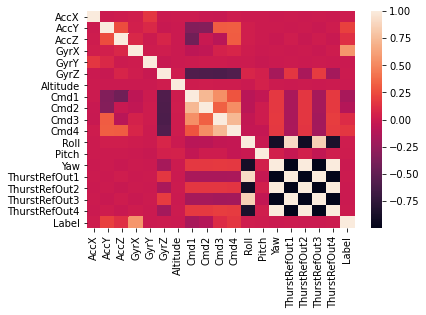

In [ ]:
import seaborn as sns

sns.heatmap(df.corr())
plt.show()

In [ ]:
new_cols = ["AccX","AccY","AccZ","GyrX","GyrY","GyrZ","Cmd4","Cmd3","Label"]

In [ ]:
df = df[new_cols]

In [ ]:
df.shape

(3075000, 9)

In [ ]:
df["Label"].value_counts()

0    1885107
3     306630
4     300858
1     297929
2     284476
Name: Label, dtype: int64

In [ ]:
df["Label"].unique()

array([0, 1, 2, 3, 4])

#### Data Normalization

In [ ]:
y = df["Label"]
X = df.drop("Label",axis= 1)

In [ ]:

from sklearn.preprocessing import RobustScaler
new_cols = ["AccX","AccY","AccZ","GyrX","GyrY","GyrZ","Cmd4","Cmd3"]
scale_columns = new_cols

scaler = RobustScaler()

scaler = scaler.fit(X[scale_columns])

X.loc[:, scale_columns] = scaler.transform(X[scale_columns].to_numpy())


In [ ]:
n_features = len(new_cols)

#### Creating Sliding Windows

In [ ]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        # print(v.shape)
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 64
STEP = 40

print(X.shape)
X_train, y_train = create_dataset(
    X[new_cols], 
    y, 
    TIME_STEPS, 
    STEP
)
print(X_train.shape)


(3075000, 8)
(76874, 64, 8)


In [ ]:
# Reshape data to feed into the Network
X_train = X_train.reshape(X_train.shape[0],4,int(TIME_STEPS/4),n_features)

In [ ]:
print(X_train.shape, y_train.shape)


(76874, 4, 16, 8) (76874, 1)


In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)

print(np.asarray((unique, counts)).T)

[[    0 47410]
 [    1  7363]
 [    2  7045]
 [    3  7603]
 [    4  7453]]


#### Label encoding 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
# y_test = enc.transform(y_test)

In [ ]:
print(X_train.shape, y_train.shape)


(76874, 4, 16, 8) (76874, 5)


### Create the Hybrid CNN-LSTM Architecture

In [ ]:
model = Sequential()
# Add 3 CNN models with 32 filters and window size of 4
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='relu'), input_shape=(4,int(TIME_STEPS/4), n_features)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=4, activation='relu')))
# model.add(Dropout(0.2))

model.add(TimeDistributed(Conv1D(filters=32, kernel_size=4, activation='relu')))
model.add(TimeDistributed(Dropout(0.4)))
# Add max-pooling layer
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# The extracted features are then flattened and provided to the LSTM model to read
model.add(TimeDistributed(Flatten()))
# Add LSTM Model
model.add(LSTM(150))
# Use Dropout layer to reduce overfitting of the model to the training data
model.add(Dropout(0.3))
# Add one hidden layer with 100 default nodes with relu activation function
model.add(Dense(50, activation='relu'))
# Add output layer with 6 (Total number of classes) nodes with softmax activation function
model.add(Dense(5, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, 4, 13, 32)         1056      
_________________________________________________________________
time_distributed_13 (TimeDis (None, 4, 10, 32)         4128      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 4, 7, 32)          4128      
_________________________________________________________________
time_distributed_15 (TimeDis (None, 4, 7, 32)          0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 4, 3, 32)          0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 4, 96)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)              

### Train the Model

In [ ]:
# Function for plotting Acuracy and Loss
def plot_training(history):
    print(history.history.keys())

    #  "Accuracy"
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # "Loss"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Epoch 1/100
961/961 [==============================] - 9s 8ms/step - loss: 0.6769 - accuracy: 0.7085 - val_loss: 0.3411 - val_accuracy: 0.9117
Epoch 2/100
961/961 [==============================] - 7s 7ms/step - loss: 0.4788 - accuracy: 0.7831 - val_loss: 0.2660 - val_accuracy: 0.9251
Epoch 3/100
961/961 [==============================] - 7s 7ms/step - loss: 0.4117 - accuracy: 0.8179 - val_loss: 0.1017 - val_accuracy: 0.9800
Epoch 4/100
961/961 [==============================] - 7s 7ms/step - loss: 0.3734 - accuracy: 0.8368 - val_loss: 0.0958 - val_accuracy: 0.9740
Epoch 5/100
961/961 [==============================] - 7s 7ms/step - loss: 0.3462 - accuracy: 0.8501 - val_loss: 0.1494 - val_accuracy: 0.9602
Epoch 6/100
961/961 [==============================] - 7s 7ms/step - loss: 0.3282 - accuracy: 0.8610 - val_loss: 0.4709 - val_accuracy: 0.6693
Epoch 7/100
961/961 [==============================] - 7s 7ms/step - loss: 0.3135 - accuracy: 0.8678 - val_loss: 0.2354 - val_accuracy: 0.9436

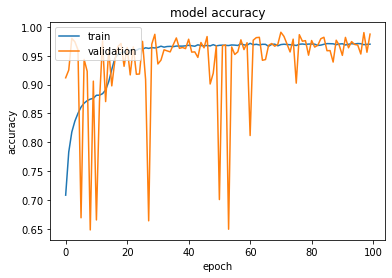

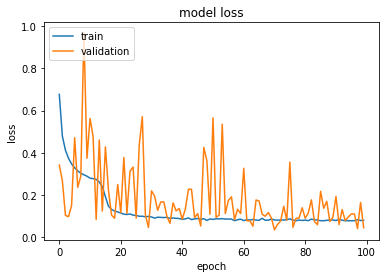

In [ ]:
def training(model, X_train, y_train):
    # Another control put in place to handle overfitting
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1,patience=20,mode='min',restore_best_weights=True)

    initial_learning_rate = 0.00001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 100000,
    decay_rate = 0.96,
    staircase = True)

   
    opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
    # opt = tfa.optimizers.SWA(tf.keras.optimizers.SGD(), 100, 10)
    # compile the model and Start training
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy']) 

    history = model.fit(X_train, y_train,epochs=100,batch_size=64,validation_split=0.2,shuffle=True)
    #callbacks=[early_stopping]
    print(history.history.keys())
    # plot training performance over the epochs
    plot_training(history)
    return history

history= training(model, X_train, y_train)

### Save the Model

In [ ]:
import datetime
model.save("Gyr_Models/"+Category+"_"+str(TIME_STEPS)+"_"+f'{datetime.datetime.today().strftime("%d-%m-%Y")}.h5')